In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pyshtools

def mean_square(L=None, delta_x=None, y=None):
    return (1 / L) * np.sum(y * y * delta_x)

def rms(x):
    return np.sqrt(np.mean(x**2))

def total_power_parseval(psd=None, delta_k=None):
    return (1.0 / (2.0 * np.pi)) * np.sum(psd * delta_k)

def parseval_rms(psd, k):
    # RMS from power spectral density using parseval's theorem
    f = psd
    I = np.trapz(f, k)
    rms = np.sqrt(I/(2*np.pi))
    return rms

def parseval_rms_2D(psd, k):
    # RMS from power spectral density using parseval's theorem
    f = psd*2*np.pi*k
    I = np.trapz(f, k)
    rms = np.sqrt(I/(2*np.pi)**2)
    return rms

def k_to_l(k, R):
    return k * 2 * np.pi * R - 0.5

def l_to_k(l, R):
    return (l + 0.5) / (2 * np.pi * R)

/home/claire/miniconda3/lib/python3.8/site-packages/pyshtools/shclasses/shcoeffs.py:2383: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


RMS of 2D psd 0.4695426498828097 km
l [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
wl: [80060.34718408 26686.78239469 16012.06943682 11437.19245487
  8895.59413156  7278.21338037  6158.48824493  5337.35647894
  4709.4321873   4213.70248337  3812.39748496  3480.88466018
  3202.41388736  2965.19804385  2760.70162704  2582.59184465
  2426.07112679  2287.43849097  2163.79316714  2052.82941498
  1952.69139473  1861.86853916  1779.11882631  1703.41164221
  1633.88463641  1569.8107291   1510.57258838  1455.64267607
  1404.56749446  1356.95503702  1312.46470794]
PSD, l 0-3 [0.         0.00124443 0.00299768 0.00199284]
RMS of map 0.4724893371692155 km


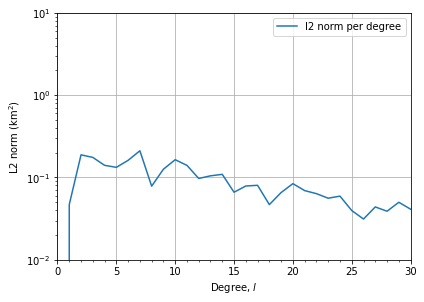

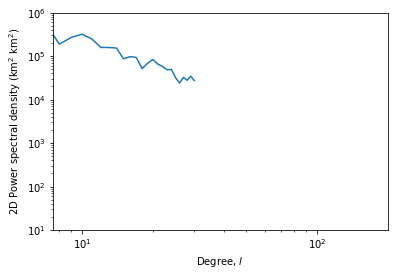

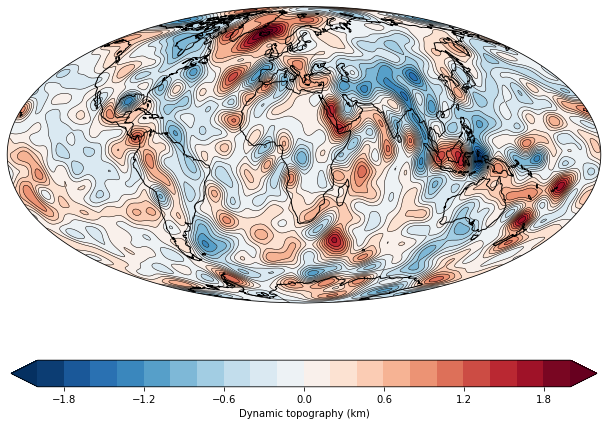

In [21]:
# copied from hoggard.py

path = '/home/claire/Works/exo-top/benchmarks/hoggard/'
filename = 'NGS-2015-07-01303-s13.csv'   # Hoggard et al. (2016) file for dynamic topography
lmax_data = 30   # spherical harmonic degree of Hoggard model
lmax_plot = 120  # spherical harmonic degree to use for plotting purposes

sh = np.loadtxt(path + filename, delimiter=",")
cilm = np.zeros((2, lmax_data+1, lmax_data+1))
for i in range(sh.shape[0]):
    l = int(sh[i,0])
    m = int(sh[i,1])
    coeff = sh[i,2]
    if m>0:
        cilm[1, l, m] = coeff/1e3  # 1e3 for converting from m to km
    else:
        cilm[0, l, -m] = coeff/1e3

# Hoggard uses "fully normalized" coefficients with the Condon-Shortley phase convention (like seismologists)
clm= pyshtools.SHCoeffs.from_array(cilm,lmax=30,normalization="ortho",csphase=-1)

# Mimic Figure 5 -- plot of l2 norm spectrum (not really power, out by 4pi)
fig1, ax1 = clm.plot_spectrum(unit="per_l",xscale='lin',yscale='log',convention="l2norm")
plt.xlim([0,30])
plt.ylabel("L2 norm (km$^2$)")
plt.xlabel("Degree, $l$")
plt.ylim(np.array([1e-2, 1e1]))

# 2D power spectral density
plt.figure()
spectrum = clm.spectrum(unit='per_lm')
R = 6371.0 # km
l = clm.degrees()
plt.loglog(l, 4.0*np.pi*R*R*spectrum)
plt.xlim(-0.5+2.0*np.pi*R/5000.0, -0.5+2.0*np.pi*R/200.0)
plt.ylim(1e1,1e6)
plt.xlabel("Degree, $l$")
plt.ylabel("2D Power spectral density (km$^2$ km$^2$)")

wl = 2*np.pi*R / (l + 0.5)
k = 2*np.pi/wl
print('RMS of 2D psd', parseval_rms_2D(4.0*np.pi*R*R*spectrum, k), 'km')


# Expand onto a regular lat/lon grid for plotting
topo = clm.expand(lmax=lmax_plot)
data = topo.data
lats = topo.lats()
lons = topo.lons()

# Aid plotting by repeating the 0 degree longitude as 360 degree longitude
lons = np.hstack([lons,np.array([360.0])])
v = data[:,0]
v=v.reshape((v.shape[0],1))
data = np.hstack([data, v])
print('RMS of map', rms(data), 'km')

# Cartopy plot
import cartopy.crs as ccrs

data_crs = ccrs.PlateCarree()
proj_crs = ccrs.Mollweide(central_longitude=22.5)

fig=plt.figure(figsize=(12,7))
ax = plt.axes(projection=proj_crs)
ax.set_global()
ax.coastlines()
V = np.arange(-2000,2200,200)/1e3
cf= ax.contourf(lons, lats, data,cmap='RdBu_r',levels=V, transform=data_crs, extend="both")
ct = ax.contour(lons,lats,data, levels=V, colors='black', linewidths = 0.5, linestyles = 'solid', transform=data_crs)
cbar = plt.colorbar(cf, orientation = 'horizontal', label='Dynamic topography (km)', fraction = 0.07)


# # Produce cartopy plot of just degrees 0-3
# # Expand onto a regular lat/lon grid for plotting
# clm_low = clm
# clm.coeffs[:,4:,:]=0.0
# topo = clm.expand(lmax=lmax_plot)
# data = topo.data
# lats = topo.lats()
# lons = topo.lons()

# # Aid plotting by repeating the 0 degree longitude as 360 degree longitude
# lons = np.hstack([lons,np.array([360.0])])
# v = data[:,0]
# v=v.reshape((v.shape[0],1))
# data = np.hstack([data, v])
# print('RMS of map, degrees 0-3', rms(data), 'km')

# # Cartopy plot

# fig=plt.figure(figsize=(12,7))
# ax = plt.axes(projection=proj_crs)
# ax.set_global()
# ax.coastlines()
# V = np.arange(-2000,2200,200)/1e3
# cf= ax.contourf(lons, lats, data,cmap='RdBu_r',levels=V, transform=data_crs, extend="both")
# ct = ax.contour(lons,lats,data, levels=V, colors='black', linewidths = 0.5, linestyles = 'solid', transform=data_crs)
# cbar = plt.colorbar(cf, orientation = 'horizontal', label='Dynamic topography (km)', fraction = 0.07)



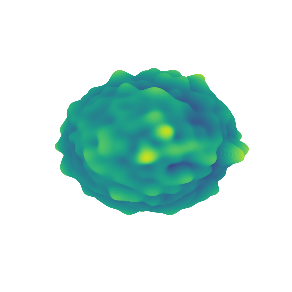

In [24]:
fig, ax = topo.plot3d(elevation=200, azimuth=0, show=False)

In [101]:
def load_psd(case, data_path=''):
    import pickle as pkl
    
    fname = data_path + 'output-' + case + '/pickle/' + case + '_sph.pkl'
    psd, k = pkl.load(open(fname, "rb"))
    
    return psd, k

def fit_slope(S, k, k_min=None, k_max=None, ax=None, fmt='g-', plot=True, **kwargs):
    # find k range
    if k_min is not None and (k_min > np.min(k)):
        i_min = np.argmax(k >= k_min)
    else:
        i_min = 0
    if k_max is not None and (k_max < np.max(k)):
        i_max = np.argmax(k >= k_max) + 1
    else:
        i_max = -1
    kv = k[i_min:i_max]
    Sv = S[i_min:i_max]

    try:
        intercept, slope = np.polynomial.polynomial.polyfit(np.log10(kv), np.log10(Sv), deg=1)
    except TypeError as e:
        print('k', k)
        print('  min, max', k_min, k_max)
        raise e

    intercept = 10**intercept
    print('         slope, 10^intercept:', slope, intercept)
    beta = -slope

    if plot:
        if ax is None:
            ax = plt.gca()
        ax.plot(kv, intercept * kv ** -beta, fmt, label=r'naive fit, $\beta$ = ' + '{:.2f}'.format(beta))
        ax.legend()
    return beta, intercept

def interpolate_degrees(phi, kv, R, lmin=2, kmin_fit=6.283185307179586, kmax_fit=26.978963599955573):

    beta, intercept = fit_slope(phi, kv, k_min=kmin_fit, k_max=kmax_fit, plot=False)
    
    lmin_fit = int(np.ceil(-0.5 + kmin_fit*R))
    lmax_fit = int(np.floor(-0.5 + kmax_fit*R))
    l = np.arange(lmin_fit, lmax_fit+1)
    
    kl = (l + 0.5) / R
    Sl = intercept * kl ** -beta  # psd at wavenumber corresponding to range of l
    
    # insert lower degrees - flat
    p0 = Sl[0]
    Sl = np.insert(np.array(Sl), 0, [p0] * (lmin_fit - lmin))
    Sl = np.insert(np.array(Sl), 0, [0.0] * lmin)  # no power at l=0,1
    l = np.insert(np.array(l), 0, np.arange(lmin_fit))

    return l, Sl

In [260]:
def coeffs_to_grid(clm, R=6371.0, lmax_plot=120, plot_grid=True, plot_spectrum=True, clabel='Dynamic topography (km)',
                  cmap='terrain', labelsize=14, d=1, alpha_m=1, dT=1, verbose=False):

    l = clm.degrees()
    k = (l + 0.5) / R
    
    if verbose:
        print('\n///// expanding coeffs to grid')
    
#     spectrum = clm.spectrum(unit='per_lm')  # 2D power spectral density
#     l = clm.degrees()
#     wl = 2*np.pi*R / (l + 0.5)
#     k = 2*np.pi/wl
#     if verbose:
#         print('RMS of 2D psd', parseval_rms_2D(4.0*np.pi*R*R*spectrum, k), 'km')
    
#     if plot_spectrum:
#         plt.figure()
#         plt.loglog(l, 4.0*np.pi*R*R*spectrum)
# #         plt.xlim(-0.5+2.0*np.pi*R/5000.0, -0.5+2.0*np.pi*R/200.0)
# #         plt.ylim(1e1,1e6)
#         plt.xlabel("Degree, $l$")
#         plt.ylabel("2D Power spectral density (km$^2$ km$^2$)")

    # Expand onto a regular lat/lon grid for plotting
    topo = clm.expand(lmax=lmax_plot)
    data = topo.data
    lats = topo.lats()
    lons = topo.lons()
    
    data = data / np.pi**2
    
    data = data*d*dT*alpha_m

    # Aid plotting by repeating the 0 degree longitude as 360 degree longitude
    lons = np.hstack([lons,np.array([360.0])])
    v = data[:,0]
    v=v.reshape((v.shape[0],1))
    data = np.hstack([data, v])
    
    h_rms = rms(data)
    h_peak = np.max(data)
    h_peak_abs = np.max(abs(data))
    if verbose:
        print('RMS of map', h_rms, 'km')
    
    
    if verbose:
        print('test from SHTOOLS notebook')
        grid_dh = clm.expand(grid='DH')
        weights = pyshtools.utils.DHaj(grid_dh.n)
        N = ((grid_dh.data[:grid_dh.nlat-grid_dh.extend, :grid_dh.nlon-grid_dh.extend]**2) * weights[np.newaxis,:].T).sum() * 2. * np.sqrt(2.) * np.pi / (grid_dh.nlon-grid_dh.extend)
        print('N = ', N)
        print('Variance of Ylm = ', N / (4. * np.pi))
        print('root = ', np.sqrt(N / (4. * np.pi)), 'should equal rms')
    
    
    if plot_grid:        
        fig, ax = plt.subplots(1, 1)
        mappable = ax.imshow(data, extent=(0, 360, -90, 90), cmap=cmap)
        ax.set(yticks=np.arange(-90, 120, 30), xticks=np.arange(0, 390, 30))
        ax.set_xlabel('Latitude', fontsize=labelsize)
        ax.set_ylabel('Longitude', fontsize=labelsize)
        cbar = plt.colorbar(mappable, orientation='horizontal', label=clabel,
                            fraction=0.07)

    # calculate basin capacity
    annulus_vol = 4 / 3 * np.pi * ((R + h_peak_abs) ** 3 - R ** 3)
    
    vol_rock = 0
    vol_ocn = 0
    nx = len(lons)
    ny = len(lats)
    dx = 2*np.pi*R / nx  # circumference 
    dy = np.pi*R / ny  # pole-to-pole distance
    for ii in range(nx):
        for jj in range(ny):
            vol_rock = vol_rock + abs(data[jj, ii]) * dx * dy
            vol_ocn = vol_ocn + (h_peak - data[jj, ii]) * dx * dy  # posi h
#             net_vol = net_vol + data[jj, ii] * dx * dy
    if verbose:
        print('spherical annulus vol:', annulus_vol)
        print('integrated vol:', vol_ocn)
        print('mean h', np.mean(data), 'min h', np.min(data), 'max h', np.max(data))

    return h_rms

In [261]:
def random_harms_from_psd(psd, k, R=2, h_ratio=1, norm='ortho',
                          kmin_fit=6.283185307179586, kmax_fit=26.978963599955573, plot=True, verbose=True):
    
#     d, dT, alpha = 2890, 3000, 3e-5  # Hoggard AGU Monograph
    d, dT, alpha = 1, 1, 1
    psd = np.array(psd) * d**3 * alpha**2 * dT**2
    k = np.array(k) * d**-1
    R = R*d

    l_orig = -0.5+k*R

    if verbose:
        print('RMS of 1D psd', parseval_rms(psd, k), 'km')

    if plot:
        fig = plt.figure()
        plt.loglog(l_orig, psd, label='1D PSD')
        plt.xlabel("Degree, $l$")
        plt.ylabel("Power")
        

    lhat, phihat = interpolate_degrees(psd, k, R=R, lmin=2, 
                                       kmin_fit=kmin_fit/d, kmax_fit=kmax_fit/d)
    khat = (lhat + 0.5) / R
    
    if plot:
        plt.loglog(lhat, phihat, c='k', ls='--', label='Interpolated model')

    if verbose:
        print('\nRMS of model 1D psd', parseval_rms(phihat, khat), 'km')

    l = lhat  # should be integers starting at 0
    k = khat
    lmax = np.max(l)
    
    # convert 1D psd (km^2 km) to power (km^2)
    phi_1D = phihat
    phi_2D_iso = np.pi/k * phi_1D  # convert to 2D iso PSD assuming radial symmetry (Jacobs eqn 5)
              
    if verbose:
        print('\nRMS of model 2D iso psd', parseval_rms(phi_2D_iso, khat), 'km')  # works!
#         print('\n      ....pi scaled', parseval_rms(phi_2D_iso, khat)/np.pi**2, 'km')
    
    S = np.array(phi_2D_iso) * (2*l + 1)
    
    # optional scaling to new rms
    S = np.array(S)*h_ratio**2  
    
    if plot:
        plt.loglog(l, S, label='Power per l, model', ls='--')

    # generate new model spectra from random
    if verbose:
        print('\n///// new randomised spectra')
        
    coeffs_global = pyshtools.SHCoeffs.from_random(S, normalization=norm, lmax=lmax)

    degrees = coeffs_global.degrees()
    k = (degrees + 0.5) / R
    power_per_l = coeffs_global.spectrum(unit='per_l')
    power_per_lm = coeffs_global.spectrum(unit='per_lm')
    psd_1D_random = power_per_lm * k/np.pi
    psd_2D_scaled = 4*np.pi*R**2*power_per_lm
    
    
    psd_random = power_per_l / (2*degrees + 1) * k/np.pi
    

    if verbose:
        print('RMS of generated 1D (rad avg) psd', parseval_rms(psd_1D_random, k), 'km')
        print('RMS of unscaled 2D (iso) psd', parseval_rms_2D(power_per_lm, k), 'km')
        print('RMS of generated 2D (iso) psd', parseval_rms_2D(psd_2D_scaled, k), 'km')
        
#         print('        .....if it were 1D', parseval_rms(psd_2D*k, k), 'km')

    if plot:
        plt.loglog(degrees, power_per_l, label='Power per l randomised')
        plt.loglog(degrees, power_per_lm, label='2D PSD randomised')
        plt.loglog(degrees, psd_random, label='1D iso PSD randomised')

    
#     # now if you generate coeffs, but convert to psd simply and pretend it's 1D
#     psd_random = power_per_l / (2*degrees + 1)
#     if verbose:
#         print('RMS of S_l / (2l + 1)', parseval_rms(psd_random, k))
#     if plot:
#         plt.loglog(degrees, psd_random, label='reversed PSD randomised')

    if plot:
        plt.legend()
    
    return coeffs_global




RMS of 1D psd 0.008963907301733642 km
         slope, 10^intercept: -5.210465129950153 0.46366899811046286

RMS of model 1D psd 0.0050939016378590135 km

RMS of model 2D iso psd 0.00481409286489428 km

///// new randomised spectra
RMS of generated 1D (rad avg) psd 0.005513851009261488 km
RMS of unscaled 2D (iso) psd 0.00977304645468479 km
RMS of generated 2D (iso) psd 0.06928909529473823 km

///// expanding coeffs to grid
RMS of map 2.0355319539427197 km
test from SHTOOLS notebook
N =  0.0603320469700165
Variance of Ylm =  0.004801071751065266
root =  0.06928976656812509 should equal rms
spherical annulus vol: 2677817364.949586
integrated vol: 4000752948.7972407
mean h 0.304674788292606 min h -5.337558117235664 max h 6.3714278239471245
         slope, 10^intercept: -5.210465129950153 0.46366899811046286
new h ratio from grids 1.4957817949889955


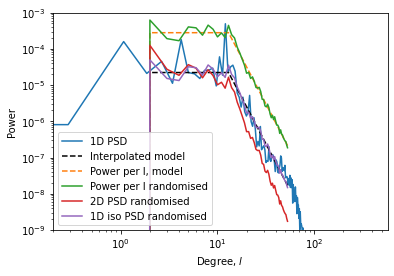

In [263]:
data_path = '/home/claire/Works/aspect/runs/model-output/'
case = 'Ra1e8-eta1e7-wide'
# known RMS of profile 0.008902079935571126

# d, dT, alpha = 1, 1, 1
d, dT, alpha = 2890, 3000, 3e-5  # Hoggard AGU Monograph
verbose=True
plot=False

psd, k = load_psd(case, data_path)

# original
h_ratio = 1
clm = random_harms_from_psd(psd, k, R=2, h_ratio=h_ratio, plot=True, verbose=verbose, norm='ortho')
ax = plt.gca()
ax.set_ylim((1e-9, 1e-3))

h_rms = coeffs_to_grid(clm, plot_grid=plot, plot_spectrum=False, d=d, alpha_m=alpha, dT=dT, R=2*d,
               clabel='Dynamic topography', verbose=verbose,)

# for h x2
h_ratio = 2
clm = random_harms_from_psd(psd, k, R=2, h_ratio=h_ratio, plot=False, verbose=False)
h_rms2 = coeffs_to_grid(clm, plot_grid=plot, plot_spectrum=False, d=d, alpha_m=alpha, dT=dT, R=2*d,
               clabel='Dynamic topography', verbose=False)

print('new h ratio from grids', h_rms2/h_rms)

0.4724893371692155

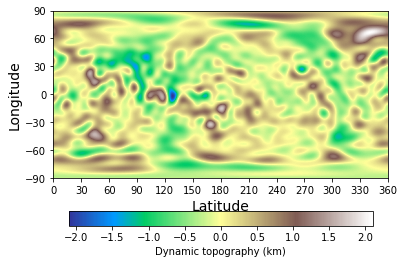

In [233]:
sh = np.loadtxt(path + filename, delimiter=",")
cilm = np.zeros((2, lmax_data+1, lmax_data+1))
for i in range(sh.shape[0]):
    l = int(sh[i,0])
    m = int(sh[i,1])
    coeff = sh[i,2]
    if m>0:
        cilm[1, l, m] = coeff/1e3  # 1e3 for converting from m to km
    else:
        cilm[0, l, -m] = coeff/1e3

# Hoggard uses "fully normalized" coefficients with the Condon-Shortley phase convention (like seismologists)
clm= pyshtools.SHCoeffs.from_array(cilm,lmax=30,normalization="ortho",csphase=-1)

coeffs_to_grid(clm, lmax_plot=120, plot_grid=True, plot_spectrum=True, clabel='Dynamic topography (km)')